In [69]:
def check_plotly():
    package = 'plotly'
    try:
        return __import__(package)
    except ImportError:
        import sys
        !conda install  --yes --prefix {sys.prefix} -c plotly plotly=5.1.0
        return None
def check_seaborn():
    package = 'seaborn'
    try:
        return __import__(package)
    except ImportError:
        import sys
        !conda install  --yes --prefix {sys.prefix} -c check_seaborn
        return None

In [70]:
print(check_plotly())
print(check_seaborn())

<module 'plotly' from '/home/caio/anaconda3/lib/python3.8/site-packages/plotly/__init__.py'>
<module 'seaborn' from '/home/caio/anaconda3/lib/python3.8/site-packages/seaborn/__init__.py'>


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
import math
import plotly.graph_objects as go

In [72]:
df = pd.read_csv("../raw_data.csv")
# df = pd.read_csv("../final_dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3917 entries, 0 to 3916
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Editora       3917 non-null   object 
 1   ISBN          3917 non-null   object 
 2   Ano           3917 non-null   float64
 3   Edição        3917 non-null   float64
 4   Origem        3917 non-null   object 
 5   Encadernação  3917 non-null   object 
 6   Idioma        3917 non-null   object 
 7   País          3917 non-null   object 
 8   Páginas       3917 non-null   float64
 9   preço         3917 non-null   float64
 10  nome          3917 non-null   object 
 11  categoria     3917 non-null   object 
 12  Autores       3916 non-null   object 
dtypes: float64(4), object(9)
memory usage: 397.9+ KB


In [73]:
k = int(1 + 3.3 * math.log10(df.shape[0]))
plt.rcParams["figure.figsize"] = (12, 7)

# Removendo campo não relevantes (identificadores)

In [74]:
df = df.drop(['ISBN'],axis=1)

# Analisando features numéricas

In [75]:
df.describe()

,Ano,Edição,Páginas,preço
count,3917.000000,3917.000000,3917.000000,3917.000000
mean,2014.596630,3.346183,287.652285,67.643572
std,6.634379,64.398312,256.673567,71.241467
min,1966.000000,1.000000,2.000000,1.710000
25%,2012.000000,1.000000,151.000000,39.500000
50%,2016.000000,1.000000,232.000000,49.900000
75%,2019.000000,1.000000,340.000000,73.790000
max,2021.000000,2016.000000,4032.000000,1551.000000


## Correlação entre features numéricas

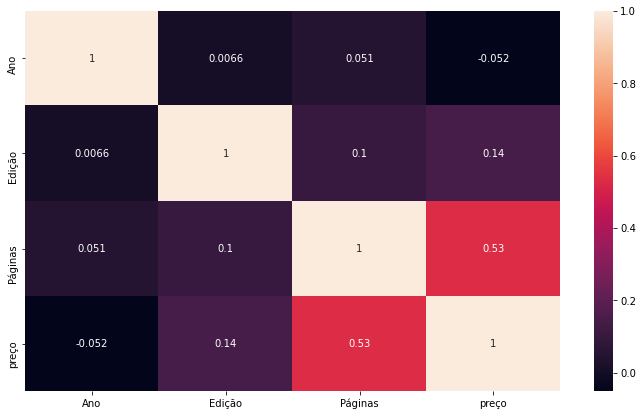

In [76]:
corr = df.corr(method='spearman')
sn.heatmap(corr, annot=True)
plt.show()

### Apenas o número de páginas parece ter uma correlçao positiva relevante

In [77]:
fig = px.scatter_matrix(df,
    dimensions=["Ano", "Edição", "Páginas", "preço"],
    # color="species", symbol="species",
    title="Scatter matrix dos atributos numéricos",
    labels={col:col.replace('_', ' ') for col in df.columns},width=1000,height=800,hover_name='nome') # remove underscore
fig.update_traces(diagonal_visible=False)
fig.show()

### De fato, não parece haver nenhuma correlação linear marcante. No entanto, é visível que o númro de páginas tem certa influência no preço. Além disso, nos últimos anos parece haver livros com um maior número de páginas e com um maior preço.

# Analisando a feature Ano

## Qual a distribuilção dos livros por ano?

In [78]:
cats = ['MEDICINA','INFORMÁTICA E TECNOLOGIA','CIÊNCIAS EXATAS','VIDEOGAMES','HQS','ECONOMIA','CIÊNCIAS BIOLÓGICAS']
df['Edição'] = df['Edição'].astype(str) #Converte edição para string para melhorar a visualização das barras

In [79]:
fig = px.histogram(df, x="Ano",nbins=k,title="Histograma do atributo ano")
fig.show()

In [80]:
ano_dist = df['Ano'].value_counts().reset_index(name='quantidade').sort_values(by='index').rename(columns={'index':'Ano'})
fig = px.line(ano_dist, x="Ano", y="quantidade", title='Livros publicados por ano')
fig.show()

### A quantidade de livros publicados vem aumentando consideravelmente

In [81]:
ano_cat_dist = df[df['categoria'].isin(cats)].groupby(by=['Ano','categoria']).size().reset_index(name='counts')
fig = px.line(ano_cat_dist, x="Ano", y="counts", color='categoria',title='Quantidade de livros publicados por ano e categoria')
fig.show()

### Livros de medicina tiveram um boom em publicações em 2021, mesmo conseiderando apenas o início do ano. Com excelção dos videogames e HQs, todas as categorias tiveram crescimento em 2020 e 2021, apesar que HQs já mostra uma melhora.

In [82]:
top_5_editoras = list(df['Editora'].value_counts()[0:5].reset_index(name='quatide')['index'])

In [83]:
ano_cat_dist = df[df['Editora'].isin(top_5_editoras)].groupby(by=['Ano','Editora']).size().reset_index(name='counts')
fig = px.line(ano_cat_dist, x="Ano", y="counts", color='Editora',title='Quantidade de livros publicados por ano para as 5 principais editoras')
fig.show()

### Editora "Madras" teve um pico de publicações em 2000, mas após manteve-se em baixa, com quedas recentes. Mas no geral, todas as editoras parecem ter altos e baixos, exceto a "Companhia das letras" que parece ter uma tragetória crescente relativamente firme.

## Qual o preço médio dos livros pelo anos?

In [84]:
preco_medio_ano = df.groupby(by='Ano')['preço'].mean().reset_index(name='preço médio').rename(columns={'index':'Ano'})
fig = px.line(preco_medio_ano, x="Ano", y="preço médio", title='Preço médio por ano')
fig.show()

### Não parece haver uma tendência no preço médio, apesar de haver casos específicos que mostram que com o passar dos anos são publicados casos isolados mais caros que os demais)

In [85]:
preco_medio_ano = df[df['categoria'].isin(cats)].groupby(by=['Ano','categoria'])['preço'].mean().reset_index(name='preço médio').rename(columns={'index':'Ano'})
fig = px.line(preco_medio_ano, x="Ano", y="preço médio", color='categoria', title='Preço médio por ano e categoria')
fig.show()

## Analisando a feature Edição

In [86]:
edicoes = df['Edição'].value_counts().reset_index(name="count").rename(columns={'index':'Edição'})
fig = px.bar(edicoes, x='Edição', y='count')
fig.show()

### Grande maioria dos livros são primeira edição

In [87]:
preco_medio = df.groupby(by="Edição")['preço'].mean().reset_index(name="média")
stds = df.groupby(by="Edição")['preço'].std().fillna(0).reset_index(name="std")
media_std = preco_medio.merge(right=stds,left_on="Edição",right_on="Edição")
media_std = media_std.melt(id_vars=['Edição'],var_name='medida',value_name='valor')
media_std = media_std.sort_values(by='Edição',key= pd.to_numeric)
fig = px.bar(media_std, x='Edição', y='valor',color='medida', barmode="group")
fig.show()

#### Apesar de não haver uma correlação linear, livros que passaram da primeira edição parecem custar mais

In [88]:
# df['Edição'] = df['Edição'] .astype(str)
df_aux = df.sort_values(by='Edição',key= pd.to_numeric)
fig = px.box(df_aux, x="Edição", y="preço")
fig.show()

### Livros até a 11ª edição parecem ter uma maior variação no preço, o que já é esperado, pois existem menos exemplares de livros passado deste númro de edições

## Analisando o número de Páginas

In [89]:
df['Páginas'].value_counts().reset_index(name="count").rename(columns={'index':'Páginas'}).sort_values(by='Páginas')

,Páginas,count
288,2.0,1
294,3.0,1
80,6.0,8
238,8.0,2
52,10.0,15
...,...,...
319,2696.0,1
275,2864.0,1
337,3067.0,1
266,3586.0,1


In [90]:
fig = px.histogram(df, x='Páginas', nbins=k,title='Histograma do número de páginas')
fig.show()

### A grande maioria dos livro possuem menos de 500 páginas

In [91]:
fig = px.histogram(df[df['Páginas']<500], x='Páginas', nbins=k,title='Histograma do número de páginas, quando estas são < 500')
fig.show()

### Dentre aqueles como menos de 500 páginas, estes parecem estar seguindo uma distribuição próxima da normal

In [92]:
fig = px.scatter(df,x='Páginas',y='preço',title='Relação entre o número de páginas e o preço')
fig.show()

### Apesar de não ser uma correlação linar, quanto maior o número de páginas, maior o preço do livro

In [93]:
paginas_medio_ano = df.groupby(by='Ano')['Páginas'].mean().reset_index(name='qtd páginas médio').rename(columns={'index':'Ano'})
fig = px.line(paginas_medio_ano, x="Ano", y="qtd páginas médio", title='Número médio de páginas por ano')
fig.show()

### A média de páginas vem variando com o tempo.

In [94]:
paginas_medio_genero = df.groupby(by='categoria')['Páginas'].mean().reset_index(name='qtd páginas médio').rename(columns={'index':'categoria'}).sort_values(by="qtd páginas médio",ascending=True)
fig = px.bar(paginas_medio_genero, x="qtd páginas médio", y="categoria", title='Número médio de páginas por categoria',orientation='h', height=900)
fig.show()

### Surpreendentemente, livros de direito são os maiores, até mesmo do que dicionários

## Analisando o preço

In [95]:
fig = px.histogram(df, x="preço",nbins=k,title='Histograma dos preços dos livros')
fig.show()

### A grande maioria dos preços está entre 0 e 100 reais

In [96]:
fig = px.histogram(df[df['preço']<100], x="preço",nbins=k,title='Histogramas dos preços do livros custando entre 0 e 100 reais')
fig.show()

### Dentre aqueles como preço menor que 100, a distriuição dos preços parece seguir uma distribuição próxima da normal. Onde a maior concentração está entre 30 e 60 reais.

In [97]:
preco_medio_genero = df.groupby(by='categoria')['preço'].mean().reset_index(name='preço').rename(columns={'index':'categoria'}).sort_values(by="preço",ascending=True)
fig = px.bar(preco_medio_genero, x="preço", y="categoria", title='Preço médio por categoria',orientation='h', height=900)
fig.show()

### Em geral, livros voltados para o público "profissional" custam em média mais caro. No entanto, curiosamente "Esporte e lazer" e "Pets" também são bem caros, apesar de não se encaixarem nesse grupo.

# Analisando campos categóricos

## Analisando a encardenação

In [98]:
preco_medio_genero = df.groupby(by='Encadernação')['preço'].mean().reset_index(name='preço').rename(columns={'index':'Encadernação'}).sort_values(by="preço",ascending=False)
fig = px.bar(preco_medio_genero, x="Encadernação", y="preço", title='Preço médio por Encadernação')
fig.show()

### Como esperado, livros de capa dura são realmente mais caros do que brochura, mas surpreendentemente são também mais caros do que os capa drua com sobrecapa. Estes custam quase o dobro de um livro brochura

In [99]:
preco_medio_genero = df.groupby(by='Encadernação')['Páginas'].mean().reset_index(name='Páginas').rename(columns={'index':'Encadernação'}).sort_values(by="Páginas",ascending=False)
fig = px.bar(preco_medio_genero, x="Encadernação", y="Páginas", title='Qtd. média de Páginas por Encadernação')
fig.show()

### Curiosamente livros com capa dura e sobre capa possuem muito mais páginas do que os capa dura, mesmo sendo mais baratos.

## Análise das editoras

In [100]:
publicacoes_editora= df['Editora'].value_counts().reset_index(name="livros publicados").rename(columns={'index':'Editora'})
demais_editoras = publicacoes_editora.iloc[10:-1]
publicacoes_editora = publicacoes_editora
fig = px.bar(publicacoes_editora,x="Editora",y="livros publicados",width=1560)
fig.update_xaxes(showticklabels=False)
fig.show()

### A distribuição da publicação de livros segue uma distriuição long tail, onde as poucas principais editoras publicaram a maioria dos livros e as demais publicam poucos livros

In [110]:
publicacoes_editora = publicacoes_editora[0:10]
df_taxa = pd.DataFrame([{'Editoras':'Demais','Livros publicados':demais_editoras['livros publicados'].sum()},{'Editoras':'Top 10','Livros publicados':publicacoes_editora['livros publicados'].sum()}])
fig = px.pie(df_taxa,values='Livros publicados',names='Editoras',title='Taxa de livros publicados pelas editoras')
fig.show()

### As 10 principais editoras publicam 1/4 dos livros

In [102]:
print(f"As 10 principais editoras compreendem apenas {((10*100)/df['Editora'].nunique()):.2f}% do total de {df['Editora'].nunique()} editoras")

As 10 principais editoras compreendem apenas 1.99% do total de 502 editoras


## Analisando o País do livro

In [103]:
publicacoes_pais = df['País'].value_counts().reset_index(name='Qtd. livros').rename(columns={'index':'País'})
fig = px.pie(publicacoes_pais,values='Qtd. livros',names='País')
fig.show()

In [104]:
preco_pais = df.groupby(by='País')['preço'].mean().reset_index(name='preço médio').sort_values(by='preço médio')
fig = px.bar(preco_pais,x='preço médio',y='País',title="Preço médio por país")
fig.show()

### No geral, livros de outros países são muito mais caro do que livros brasileiros, curiosamente com exceção de livros da Itália

In [105]:
publicacao_pais_ano = df.groupby(by=['Ano','País'])['preço'].count().reset_index(name='Qtd. Livros').rename(columns={'index':'Ano'})
fig = px.line(publicacao_pais_ano, x="Ano", y="Qtd. Livros", color='País', title='')
fig.show()

### A quantidade de livros brasileiros vem aumentando firmemente, enquanto livros extrangeiros mantem-se estagnados, tendo cessado em 2019.

## Analisando autores

In [106]:
qtd_livros_autores = df['Autores'].value_counts().reset_index(name='Livros publicados').rename(columns={'index':'Autores'})
qtd_livros_autores = qtd_livros_autores[qtd_livros_autores['Autores']!= 'DESCONHECIDO']

preco_livros_autores = df.groupby(by='Autores')['preço'].mean().reset_index(name='Preço médio').rename(columns={'index':'Autores'})
preco_livros_autores = preco_livros_autores[preco_livros_autores['Autores']!= 'DESCONHECIDO']

livros_autores = preco_livros_autores.merge(qtd_livros_autores)
media_livros_publicados = livros_autores['Livros publicados'].mean()

In [107]:
qtd_livros_autores_top10 = livros_autores.sort_values(by='Livros publicados',ascending=False).iloc[0:10].sort_values(by='Livros publicados',ascending=True)
fig = px.bar(qtd_livros_autores_top10,y='Autores',x='Livros publicados',title='Top 10 de autores com mais publicações',hover_data=['Autores','Livros publicados','Preço médio'])
fig.show()

In [108]:
preco_autores_top10 = livros_autores.sort_values(by='Preço médio',ascending=False).iloc[0:10].sort_values(by='Preço médio',ascending=True)
fig = px.bar(preco_autores_top10,y='Autores',x='Preço médio',title='Top 10 autores com a maior média de preço',hover_data=['Autores','Livros publicados','Preço médio'],width=1560)
fig.show()

In [109]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=livros_autores['Livros publicados'], y=livros_autores['Preço médio'],
                    mode='markers',
                    name='autores',text=livros_autores['Autores']))
fig.add_trace(go.Scatter(x=[0,50], y=[67.643572,67.643572],
                    mode='lines',
                    name='preço médio'))
fig.add_trace(go.Scatter(x=[media_livros_publicados,media_livros_publicados], y=[0,1600],
                    mode='lines',
                    name='número médio de publicações'))
fig.update_layout(title='Relação entre a quantidade de livros publicados e a média de preços',height=800,width=1560)
fig.update_xaxes(title='Quantidade de livros publicados')
fig.update_yaxes(title='Preço médio dos livros')
fig.show()

### Parece que quanto mais publicações um autor tem, menor será a média dos preços dos seus livros. O oposto também parece ser verdade, autores cujos livros são muito caros, publicam menos.